This kernel trains a Variational Autoencoder in Keras with Gaussian input and output.

Import Keras and other necessary libraries:

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing, metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Lambda, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

/home/karen/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Read data and set train/validation/test split:

In [2]:
#read the dataset
csv = pd.read_csv("../data/creditcard.csv")

test_split = 0.3 #portion of data used for testing
val_split = 0.2 #portion of training data used for validation

Prepare training, validation and test datasets:

In [11]:
data = csv.astype('float32').copy()
data.sort_values('Time', inplace=True)

data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998,0


In [12]:
len(data.iloc[0,:])

31

In [13]:
first_test = int(data.shape[0] * (1 - test_split))
first_val = int(first_test * (1 - val_split))

train = data.iloc[:first_val]
val = data.iloc[first_val:first_test]
test = data.iloc[first_test:]

## drop Amount and Class
x_train_df, x_val_df, x_test_df = train.iloc[:, 1:-2], val.iloc[:, 1:-2], test.iloc[:, 1:-2]
y_train_df, y_val_df, y_test_df = train.iloc[:, -1], val.iloc[:, -1], test.iloc[:, -1]

x_train_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.803487,0.408542,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153


In [18]:
x_train, x_val, x_test = x_train_df.values, x_val_df.values, x_test_df.values
y_train, y_val, y_test = y_train_df.values, y_val_df.values, y_test_df.values

scaler = preprocessing.StandardScaler()

x_train, x_val, x_test = scaler.fit_transform(x_train), scaler.fit_transform(x_val), scaler.fit_transform(x_test)
x_train[0].shape

(28,)

Build the model and print summary:

In [19]:
hidden_size = 16 #size of the hidden layer in encoder and decoder
latent_dim = 2 #number of latent variables to learn

input_dim = x_train.shape[1]

x = Input(shape=(input_dim,))
t = BatchNormalization()(x)
t = Dense(hidden_size, activation='tanh' , name='encoder_hidden')(t)
t = BatchNormalization()(t)

z_mean = Dense(latent_dim, name='z_mean')(t)
z_log_var = Dense(latent_dim, name='z_log_var')(t)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, name='z_sampled')([z_mean, z_log_var])
#t = BatchNormalization()(z)

t = Dense(hidden_size, activation='tanh', name='decoder_hidden')(z)
#t = BatchNormalization()(t)

decoded_mean = Dense(input_dim, activation=None, name='decoded_mean')(t)

vae = Model(x, decoded_mean)

def rec_loss(y_true, y_pred):
    return K.sum(K.square(y_true - y_pred), axis=-1)

def kl_loss(y_true, y_pred):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

def vae_loss(x, decoded_mean):
    rec_loss = K.sum(K.square(x - decoded_mean), axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean((rec_loss + kl_loss) / 2)

vae.compile(optimizer=Adam(lr=1e-2), loss=vae_loss, metrics=[rec_loss, kl_loss])
vae.summary()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28)           0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28)           112         input_1[0][0]                    
__________________________________________________________________________________________________
encoder_hidden (Dense)          (None, 16)           464         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 16)           64       

Train the model with early stopping and a kind of learning rate schedule for the specified number of epochs with the specified batch size:

In [21]:
n_epochs = 30
batch_size = 128

early_stopping = EarlyStopping(monitor='loss', patience=10) #stop training if loss does not decrease with at least 0.00001
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, factor=0.2) #reduce learning rate (divide it by 5 = multiply it by 0.2) if loss does not decrease with at least 0.00001

callbacks = [early_stopping, reduce_lr]

#collect training data in history object
history = vae.fit(x_train, x_train, 
                  validation_data=(x_val, x_val), 
                  batch_size=batch_size, epochs=n_epochs, 
                  callbacks=callbacks)

Train on 159491 samples, validate on 39873 samples
Epoch 1/30
139136/159491 [=========================>....] - ETA: 0s - loss: 13.2387 - rec_loss: 25.1240 - kl_loss: 1.353

limit_output extension: Maximum message size of 10000 exceeded with 10128 characters

Plotting training and validation loss:

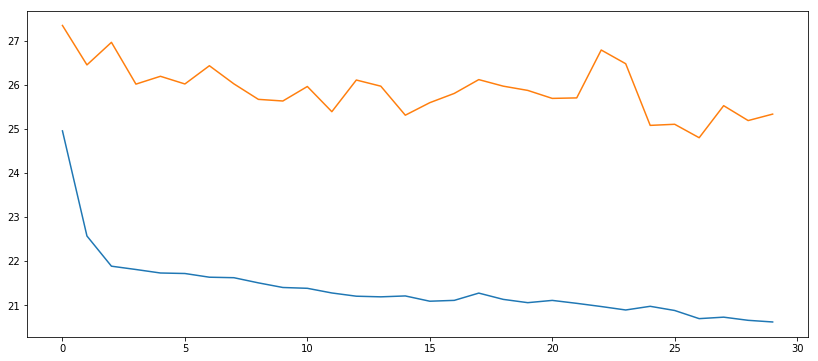

In [22]:
fig = plt.figure(figsize=(14, 6))
ax = fig.gca()
ax.plot(history.history['rec_loss']);
ax.plot(history.history['val_rec_loss']);


Plotting the learned latent representations for normal and anomalous instances in the specified dataset (training/validation/test):

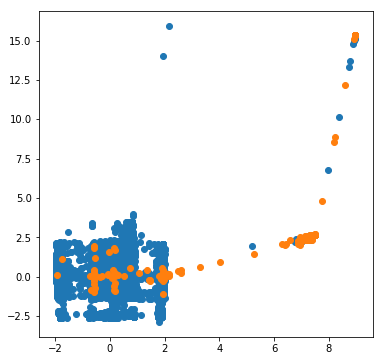

In [23]:
x_data = x_train
y_data = y_train

encoder = Model(x, z_mean)

with_labels = np.concatenate([x_data, np.reshape(y_data, (-1, 1))], axis=1) #concatenate x and y to be able to filter by class

normal = with_labels[np.where(with_labels[:, -1] == 0)] #filter normal instances
anomalous = with_labels[np.where(with_labels[:, -1] == 1)] #filter anomalous instances

normal_encoded = encoder.predict(normal[:, :-1], batch_size=128)
anomalous_encoded = encoder.predict(anomalous[:, :-1], batch_size=128)

fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

#semicolon at the end hides unnecessary output
ax.scatter(normal_encoded[:, 0], normal_encoded[:, 1]);
ax.scatter(anomalous_encoded[:, 0], anomalous_encoded[:, 1]);


Apply simple Linear Discriminant Analysis to learned features (the latent representations):

In [24]:
with_labels_encoded = encoder.predict(with_labels[:, :-1], batch_size=128)

X = with_labels_encoded
y = with_labels[:, -1]

clf = LinearDiscriminantAnalysis()
clf.fit(X, y)

pred = clf.predict(X)

print("AUC(ROC): " + str(metrics.roc_auc_score(y, pred)))
print("Precision: " + str(metrics.precision_score(y, pred)))
print("Recall: " + str(metrics.recall_score(y, pred)))
print("F1 score: " + str(metrics.f1_score(y, pred)))

tn, fp, fn, tp = metrics.confusion_matrix(y, pred).ravel()

print("False positives: " + str(fp))
print("True positives: " + str(tp))
print("False negatives: " + str(fn))
print("True negateives: " + str(tn))

AUC(ROC): 0.8705948556857421
Precision: 0.8123076923076923
Recall: 0.7415730337078652
F1 score: 0.775330396475771
False positives: 61
True positives: 264
False negatives: 92
True negateives: 159074
